In [35]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt

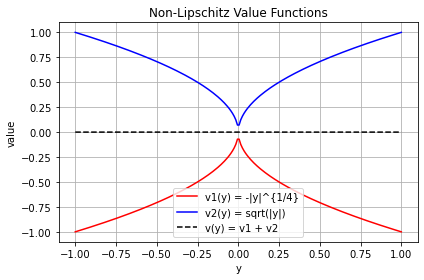

In [3]:
# 生成 y 值
y_vals = np.linspace(-1, 1, 200)
v1_list, v2_list, v_total_list = [], [], []

# 初始化求解器
solver = SolverFactory('ipopt')

for y in y_vals:
    # 场景1：v1(y) = -|y|^{1/4}
    model1 = ConcreteModel()
    model1.x1 = Var(bounds=(0, 1))
    model1.obj = Objective(expr=-model1.x1, sense=minimize)
    model1.eq = Constraint(expr=model1.x1**4 == y**2)
    
    try:
        result1 = solver.solve(model1, tee=False)
        v1 = value(model1.obj)
    except:
        v1 = np.nan

    # 场景2：v2(y) = sqrt(|y|)
    model2 = ConcreteModel()
    model2.x2 = Var(bounds=(0, 1))
    model2.obj = Objective(expr=model2.x2, sense=minimize)
    model2.con1 = Constraint(expr=model2.x2**2 >= y)
    model2.con2 = Constraint(expr=model2.x2**2 >= -y)
    
    try:
        result2 = solver.solve(model2, tee=False)
        v2 = value(model2.obj)
    except:
        v2 = np.nan

    # 合并记录
    v1_list.append(v1)
    v2_list.append(v2)
    if not np.isnan(v1) and not np.isnan(v2):
        v_total_list.append(v1 + v2)
    else:
        v_total_list.append(np.nan)

# 画图
plt.plot(y_vals, v1_list, label="v1(y) = -|y|^{1/4}", color='red')
plt.plot(y_vals, v2_list, label="v2(y) = sqrt(|y|)", color='blue')
plt.plot(y_vals, v_total_list, label="v(y) = v1 + v2", linestyle='--', color='black')
plt.title("Non-Lipschitz Value Functions")
plt.xlabel("y")
plt.ylabel("value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [4]:
model = ConcreteModel()

# 定义采样节点
breakpoints = [0.0, 0.25, 0.5, 0.75, 1.0]
values = [-z**0.5 for z in breakpoints]  # v1(z) = -sqrt(z)

# 定义变量
model.z = Var(bounds=(0, 1))  # z = |y|
model.as_approx = Var()       # piecewise approximation

# 设置 piecewise 关系
model.pw = Piecewise(
    model.as_approx, model.z,
    pw_pts=breakpoints,
    pw_constr_type='EQ',
    f_rule=lambda m, z: -z**0.5,
    pw_repn='INC'  # 增量式表示
)

# 示例目标函数：最小化 as(z)
model.obj = Objective(expr=model.as_approx, sense=minimize)

# 运行求解器
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

# 输出结果
print(f'z = {value(model.z):.4f}')
print(f'a_s(z) = {value(model.as_approx):.4f}')

Ipopt 3.14.17: 
==> Warning: Treating 3 binary and 0 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       10
Number of nonzeros in inequality constraint Jacobian.:       12
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        9
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        1
Total

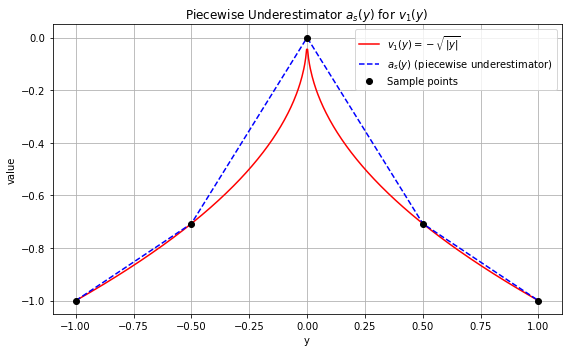

In [14]:
# 原函数 v1(y) = -sqrt(|y|)
def v1(y):
    return -np.sqrt(np.abs(y))

# 采样点（breakpoints）用于构造 piecewise 函数
y_nodes = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
z_nodes = np.abs(y_nodes)
as_nodes = -np.sqrt(z_nodes)  # 正确地为每个采样点计算函数值


# 定义细分 y 值（用于画图）
y_vals = np.linspace(-1, 1, 500)
z_vals = np.abs(y_vals)

# 构造 as(y)：z = |y|，在 z_nodes 上线性插值
as_vals = np.interp(z_vals, y_nodes, as_nodes)

# 原始函数 v1(y)
v1_vals = v1(y_vals)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(y_vals, v1_vals, label=r'$v_1(y) = -\sqrt{|y|}$', color='red')
plt.plot(y_vals, as_vals, label=r'$a_s(y)$ (piecewise underestimator)', color='blue', linestyle='--')
plt.scatter(y_nodes, as_nodes, color='black', zorder=5, label='Sample points')
plt.xlabel('y')
plt.ylabel('value')
plt.title('Piecewise Underestimator $a_s(y)$ for $v_1(y)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
print(as_nodes)


[-1.         -0.70710678 -0.         -0.70710678 -1.        ]


In [13]:
print(z_nodes)


[1.  0.5 0.  0.5 1. ]


In [31]:
from pyomo.environ import *
import numpy as np

# 采样点：构造 A_s(y)
z_nodes = [0.0, 0.5, 1.0]
as_nodes = [-np.sqrt(z) for z in z_nodes]

# 创建模型
model = ConcreteModel()
model.x1 = Var(bounds=(0, 1))
model.y = Var(bounds=(-1, 1))
model.z = Var(bounds=(0, 1))  # z = |y|

# 表达 z = |y| 用两条不等式
model.abs1 = Constraint(expr=model.z >= model.y)
model.abs2 = Constraint(expr=model.z >= -model.y)

# piecewise 表达式 A_s(z)，正确写法：f_rule 需要两个参数
model.As = Var()
model.pw = Piecewise(
    model.As, model.z,
    pw_pts=z_nodes,
    f_rule=lambda m, z: -np.sqrt(z),
    
    pw_constr_type='EQ',
    pw_repn='INC'
)

# 原始约束
model.eq = Constraint(expr=model.x1**4 == model.y**2)

# 目标函数
model.obj = Objective(expr= -model.x1 - model.As, sense=minimize)

# 求解
solver = SolverFactory('ipopt')
solver.solve(model)

# 输出结果
x1_opt = value(model.x1)
y_opt = value(model.y)
as_val = value(model.As)
m_s = -x1_opt - as_val

print(f"x1 = {x1_opt:.4f}, y = {y_opt:.4f}, A_s(y) = {as_val:.4f}, m_s = {m_s:.4f}")


x1 = 0.5000, y = 0.2500, A_s(y) = -0.2500, m_s = -0.2500


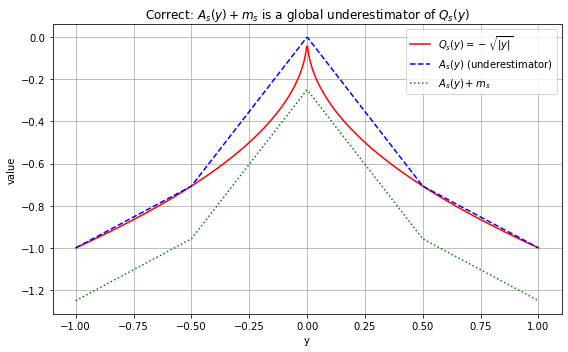

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# y 和 z = |y|
y_vals = np.linspace(-1, 1, 500)
z_vals = np.abs(y_vals)

# 原函数 Qs(y)
Qs_vals = -np.sqrt(z_vals)

# 下界 As(y)
z_nodes = np.array([0.0, 0.5, 1.0])
as_nodes = -np.sqrt(z_nodes)
As_vals = np.interp(z_vals, z_nodes, as_nodes)

# 正确的：As + ms 是 Qs 的下界
As_shifted_vals = As_vals + m_s  # 注意是 + ms，不是 - ms！

# 画图
plt.figure(figsize=(8, 5))
plt.plot(y_vals, Qs_vals, label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')
plt.plot(y_vals, As_vals, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
plt.plot(y_vals, As_shifted_vals, label=r'$A_s(y) + m_s$', color='green', linestyle=':')
plt.xlabel('y')
plt.ylabel('value')
plt.title('Correct: $A_s(y) + m_s$ is a global underestimator of $Q_s(y)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



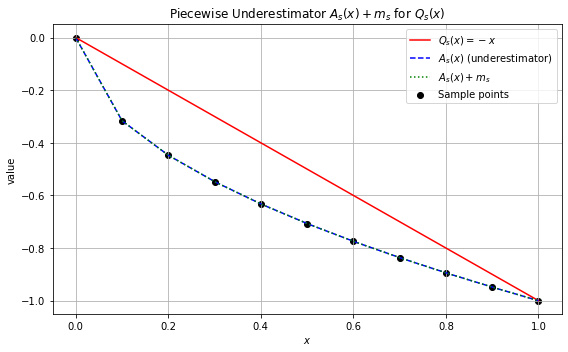

In [32]:
# 定义 Qs(x) = -x
def Qs(x):
    return -x

# 使用更多采样点构造 A_s(x)
z_nodes = np.linspace(0, 1, 11)  # 采样点：0, 0.1, ..., 1.0
as_nodes = -np.sqrt(z_nodes)     # 因为 z = |y| = x^2，所以 sqrt(z) = x，v1(y) = -sqrt(|y|)

# 定义 A_s(x) 对 x 的 piecewise 插值
x_vals = np.linspace(0, 1, 500)
as_vals = np.interp(x_vals, z_nodes, as_nodes)

# 计算 Q_s(x) 和 A_s(x)
qs_vals = Qs(x_vals)

# 计算 m_s = min(Qs(x) - As(x))
ms = np.min(qs_vals - as_vals)
as_shifted = as_vals + ms

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(x_vals, qs_vals, 'r-', label=r'$Q_s(x) = -x$')
plt.plot(x_vals, as_vals, 'b--', label=r'$A_s(x)$ (underestimator)')
plt.plot(x_vals, as_shifted, 'g:', label=r'$A_s(x) + m_s$')

plt.scatter(z_nodes, as_nodes, color='black', label='Sample points')
plt.title(r'Piecewise Underestimator $A_s(x) + m_s$ for $Q_s(x)$')
plt.xlabel(r'$x$')
plt.ylabel('value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
ms

0.0

In [36]:
import numpy as np
from pyomo.environ import *

# 节点构造（你可以选择更多点提高精度）
z_nodes = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
as_nodes = np.sqrt(z_nodes)

# 创建模型
model = ConcreteModel()
model.x2 = Var(bounds=(0, 1))
model.y = Var(bounds=(-1, 1))
model.z = Var()
model.As = Var()
model.x = Var(bounds=(-1, 1))
model.z = Var(bounds=(0, 1))  # 明确 z 的上下界

# 强制 z = |x|（使用两条不等式约束）
model.abs1 = Constraint(expr= model.z >= model.x)
model.abs2 = Constraint(expr= model.z >= -model.x)


# z = |y|
model.abs_y_pos = Constraint(expr=model.z >= model.y)
model.abs_y_neg = Constraint(expr=model.z >= -model.y)

# 分段函数 As(z) ≈ sqrt(z)
model.As = Var()

model.pw = Piecewise(
    model.As, model.z,
    pw_pts=z_nodes,
    f_rule=lambda m, z: float(np.interp(z, z_nodes, as_nodes)),
    pw_constr_type='EQ',
    pw_repn='INC'
)


# 约束 x2^2 ≥ y and x2^2 ≥ -y
model.c1 = Constraint(expr=model.x2**2 >= model.y)
model.c2 = Constraint(expr=model.x2**2 >= -model.y)

# 目标函数：min Qs(x) - As(x)
model.obj = Objective(expr=model.x2 - model.As, sense=minimize)

# 求解
solver = SolverFactory('ipopt')
results = solver.solve(model, tee=True)

# 输出结果
print("x2 =", value(model.x2))
print("y =", value(model.y))
print("z = |y| =", value(model.z))
print("As(z) =", value(model.As))
print("ms = Qs - As =", value(model.x2 - model.As))


'pyomo.core.base.var.ScalarVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.AbstractScalarVar'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.var.ScalarVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.AbstractScalarVar'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


TypeError: Invalid type '<class 'numpy.ndarray'>' for Piecewise component keyword 'pw_pts', which must be of type 'list' or 'tuple' for non-indexed Piecewise component